# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# SEGUNDA PARTE: EXPLORAR CON TÓPIC MODELING

## I. Declaración de librerías

In [1]:
# Librerías de apoyo
# ==============================================================================
from tqdm import tqdm

# Tratamiento de datos
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import mglearn

# Tratamiento de texto
# ==============================================================================
from nltk import FreqDist
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# otras configuraciones
# ==============================================================================
tqdm.pandas()

## II. Cargar y explorar el dataset

In [2]:
%%time
dataset_base = pd.read_csv("dataset_base.csv", sep='\t', encoding='utf-8')
dataset_base.sample(5)

CPU times: user 2.27 s, sys: 199 ms, total: 2.47 s
Wall time: 2.88 s


,category,title,date,abstract,content,content_for_topic,content_for_summary,abstract_for_summary
2231,MUNICIPALIDAD DE SANTIAGO DE SURCO,DECRETO DE ALCALDIA N° 10-2021-MSS,30/06/2021,Prorrogan vigencia de la Ordenanza N° 627-MSS ...,"Santiago de Surco, 25 de junio de 2021 EL ALCA...",santiago surco junio alcalde municipalidad san...,santiago surco junio alcalde municipalidad san...,prorrogan vigencia ordenanza regula campaña fa...
521,TRANSPORTES Y COMUNICACIONES,RESOLUCION MINISTERIAL N° 747-2021-MTC/01,01/08/2021,Designan Secretario General del Ministerio de ...,"Lima, 30 de julio de 2021 CONSIDERANDO: Que, s...",lima julio encontrar vacante cargo secretario ...,lima julio encuentra vacante cargo secretario ...,designan secretario general ministerio transpo...
1606,ORGANISMO SUPERVISOR DE LAS CONTRATACIONES DEL...,RESOLUCION N° 103-2021-OSCE/PRE,13/07/2021,Formalizan la aprobación de la Directiva N° 00...,"Jesús María, 12 de julio de 2021 CONSIDERANDO:...",jesú macer julio texto único ordenado contrata...,jesús maría julio texto único ordenado contrat...,formalizan aprobación directiva osce programa ...
555,MINISTERIO PUBLICO,RESOLUCION N° 1084 -2021-MP-FN,31/07/2021,Aceptan renuncia de Fiscal Adjunto Provincial ...,"Lima, 30 de julio de 2021 VISTOS Y CONSIDERAND...",lima julio visto oficio pjfssanto remitido abo...,lima julio vistos oficios nros pjfssanta remit...,aceptan renuncia fiscal adjunto provincial pro...
1357,DEFENSA,RESOLUCION MINISTERIAL N° 0353-2021-DE,17/07/2021,Autorizan pago a oficial de la Marina de Guerr...,"Lima, 15 de julio de 2021 VISTOS: El Oficio N°...",lima julio visto oficio secretaría general com...,lima julio vistos oficio secretaría general co...,autorizan pago oficial marina guerra perú conc...


In [3]:
print("Total de normas legales en el dataset:", dataset_base.shape[0])

Total de normas legales en el dataset: 4126


CPU times: user 1.1 s, sys: 10.9 ms, total: 1.11 s
Wall time: 1.1 s


<AxesSubplot:xlabel='count', ylabel='category'>

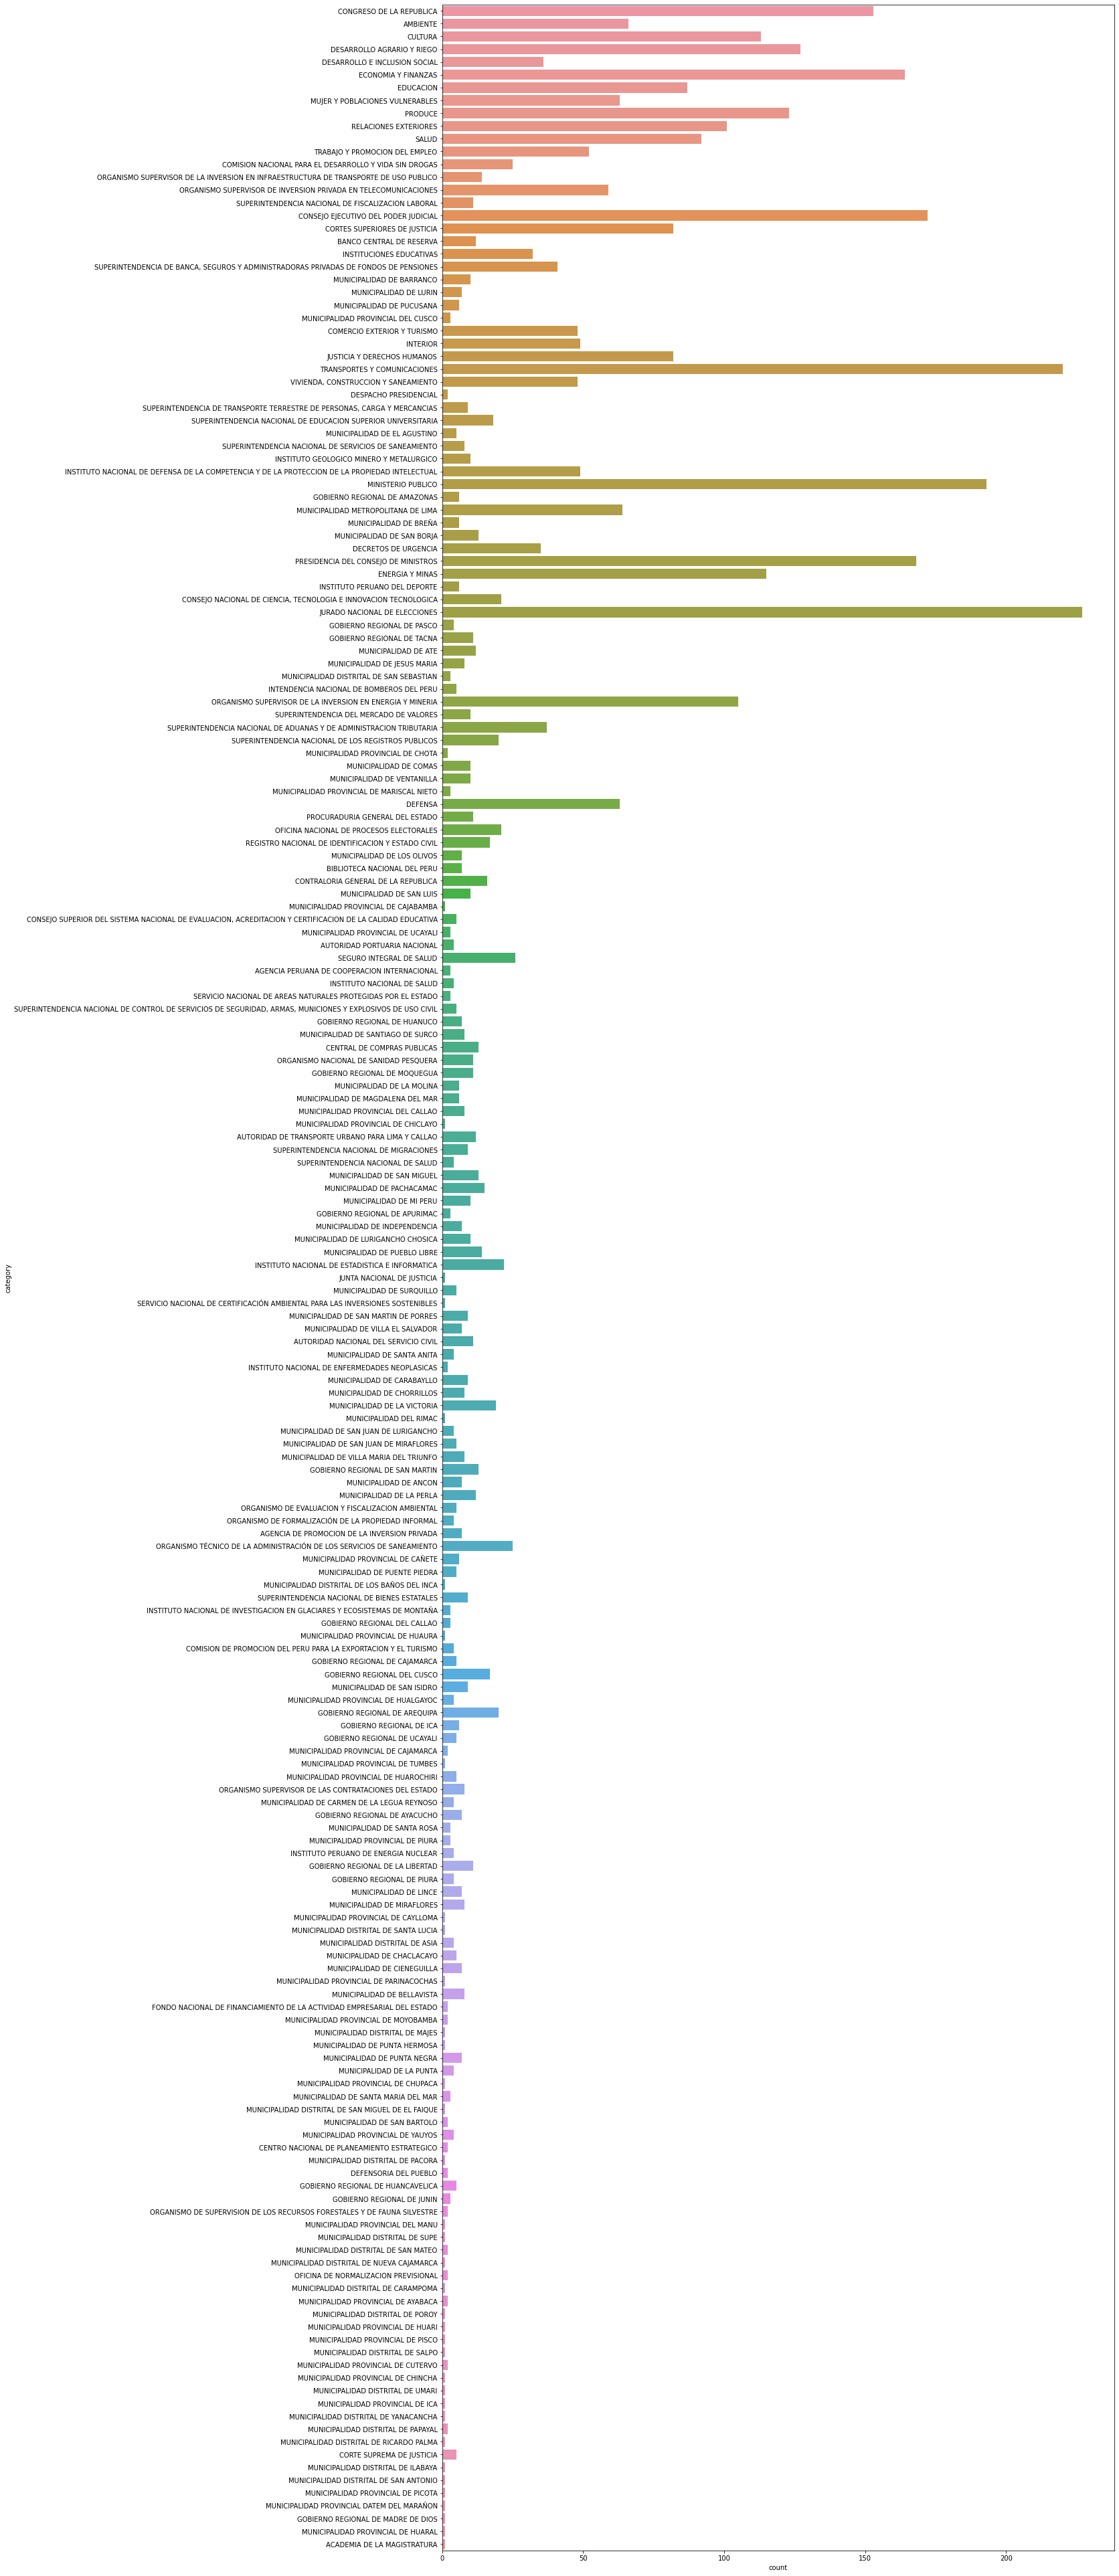

In [4]:
%%time
plt.figure(figsize=(18,70))
sns.countplot(y='category', data=dataset_base, orient='h')

___
Verificacióndel corpus
___

In [5]:
%%time
frec = FreqDist(word_tokenize(' '.join(dataset_base['content_for_topic'])))
frec.most_common(10)

CPU times: user 37.7 s, sys: 255 ms, total: 38 s
Wall time: 37.9 s


[('resolución', 25859),
 ('decreto', 24571),
 ('nacional', 21904),
 ('general', 20853),
 ('público', 18304),
 ('presente', 17268),
 ('mediante', 17136),
 ('supremo', 16177),
 ('reglamento', 13987),
 ('informe', 13746)]

In [6]:
# Tamaño de arreglo de palabras
print("Total de palabras del vacabulario:", len(frec))
print("Total de palabras que represetn lso tokens:", frec.N())

Total de palabras del vacabulario: 30665
Total de palabras que represetn lso tokens: 2941546


## III. Configurar el dataset para el Topic Modelling

___
Confirgurar y realizar proceso de vectorización/diccionario del contenido
___

In [7]:
%%time

# Representación vectorizada de todo el texto con TF-IDF
tfidf_model = TfidfVectorizer(
    max_df=0.99, # max_df : Frecuencia máxima de documentos para la palabra procesada
    max_features=20000, # max_features: númerp máximo de palabras
    min_df=0.01, # min_df : Frecuencia mínima para la palabra procesada
    use_idf=True, # use_idf: Si es falso solo calcula TF
    ngram_range=(1,1) # ngram_range: (min, max), p.e. (1, 2)incluye 1-gram, 2-gram
)

# Aplicamos el modelo 
tfidf_matrix = tfidf_model.fit_transform(dataset_base.content_for_topic) 

print("="*50)
print("En total hay {} filas (normas legales) y {} terminos.".format(
    str(tfidf_matrix.shape[0]), str(tfidf_matrix.shape[1])
))
print("="*50)

En total hay 4126 filas (normas legales) y 3214 terminos.
CPU times: user 4.65 s, sys: 19.8 ms, total: 4.67 s
Wall time: 4.69 s


___
Realizar validación cruzada para encontrar el mejor número de clusters (Hiperparáemtro).  
Se utiliza Latent Dirichlet Allocation (LDA)
___

In [8]:
%%time

# Prámetros a optimizar
#grid_params = {'n_components': list(range(1,6))}
grid_params = {'n_components': [5, 7, 10], 'learning_decay': [.5, .7, .9]}

# Modelo lda
lda = LatentDirichletAllocation()

#validación cruzada
lda_model = GridSearchCV(lda,param_grid=grid_params, verbose=1, n_jobs=20)
lda_model.fit(tfidf_matrix)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  45 out of  45 | elapsed:  3.2min finished


CPU times: user 31.4 s, sys: 509 ms, total: 31.9 s
Wall time: 3min 42s


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=20,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 7, 10]},
             verbose=1)

In [9]:
%%time
lda_model1 = lda_model.best_estimator_
print("Mejores parámetros para el modelo LDA:" , lda_model.best_params_)
print("Mejor puntage de probabilidad logísticas (veracidad) del modelo LDA",lda_model.best_score_)
print("Compljedidad del modelo LDA", lda_model1.perplexity(tfidf_matrix))

Mejores parámetros para el modelo LDA: {'learning_decay': 0.7, 'n_components': 5}
Mejor puntage de probabilidad logísticas (veracidad) del modelo LDA -64863.88971824185
Compljedidad del modelo LDA 2810.1601026594567
CPU times: user 2.78 s, sys: 3.41 ms, total: 2.79 s
Wall time: 2.78 s


## III. Topic Modelling

___
Ejecutar el modelo con los mejores parámetros (Tópicos y gradiente del Leaning Rate)
___

In [10]:
%%time
n_topics = 5
n_learning_decay=0.9
lda = LatentDirichletAllocation(n_components=n_topics, learning_decay=n_learning_decay, verbose=True).fit(tfidf_matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 28 s, sys: 15.7 ms, total: 28 s
Wall time: 28 s


___
Revisar los valores generados los tópicos generados
___

In [11]:
%%time
#  Aplicar la transformación para obtener los datos
lda_data = lda.transform(tfidf_matrix)
lda.components_[0], lda_data.shape

CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 1.7 s


(array([ 1.8188436 ,  1.03112337,  9.45696612, ...,  3.72036233,
        29.90360258,  1.28369128]),
 (4126, 5))

___
Revisar el valor de cada fila/registro (norma legal) dentro de cada tópico. 

In [19]:
%%time
# Nombres de columnas
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# Norma legal indexada
doc_names = ["Norma " + str(i) for i in range(tfidf_matrix.shape[0])]

# Crear un dateset los valores del tópico y el registro
df_document_topic = pd.DataFrame(np.round(lda_data, 3), columns=topic_names, index=doc_names)

# Obtener el tópico dominate pro cada registro
topic = np.argmax(df_document_topic.values, axis=1)

df_document_topic['TOPIC'] = topic
df_document_topic.sample(10)

CPU times: user 5.38 ms, sys: 0 ns, total: 5.38 ms
Wall time: 7.8 ms


,Topic0,Topic1,Topic2,Topic3,Topic4,TOPIC
Norma 1583,0.488,0.020,0.312,0.159,0.020,0
Norma 1577,0.638,0.024,0.025,0.025,0.289,0
Norma 2071,0.919,0.020,0.020,0.020,0.020,0
Norma 2597,0.014,0.014,0.014,0.943,0.014,3
Norma 1706,0.762,0.021,0.021,0.175,0.021,0
Norma 3709,0.864,0.034,0.034,0.034,0.034,0
Norma 2016,0.017,0.015,0.016,0.016,0.936,4
Norma 3521,0.343,0.021,0.021,0.021,0.595,4
Norma 1206,0.220,0.019,0.019,0.019,0.722,4
Norma 1615,0.060,0.022,0.874,0.022,0.022,2


___
Total registros por tópico
___

In [17]:
# Total de registros (normas legales) por tópico
df_document_topic.TOPIC.value_counts().to_frame()

,TOPIC
0,2586
2,525
3,516
4,263
1,236


<AxesSubplot:>

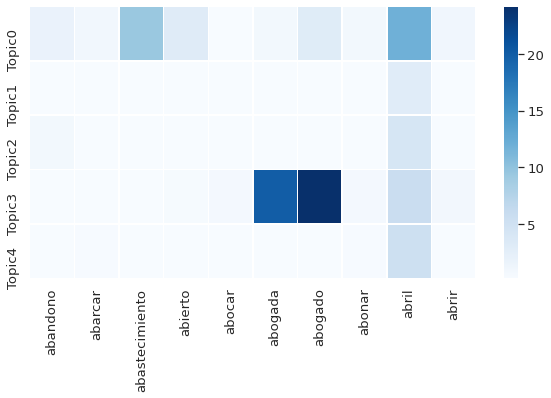

In [44]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.set(font_scale=1.2)
sns.heatmap(
            df_topic_words01.iloc[:,:10],
            linewidth=0.5,
            cmap="Blues",
            annot=False,
            fmt=".2g",
            cbar=True
        )

In [29]:
# Crear dataset de palabras por tópico
df_topic_words01 = pd.DataFrame(lda.components_)

# Datos de columna e índice
df_topic_words01.columns = tfidf_model.get_feature_names()
df_topic_words01.index = topic_names

df_topic_words01

,abandono,abarcar,abastecimiento,abierto,abocar,abogada,abogado,abonar,abril,abrir,...,óptico,óptimo,órden,órgano,óscar,último,única,únicamente,único,útil
Topic0,1.818844,1.031123,9.456966,3.189720,0.200001,0.770136,3.051239,0.814473,11.912299,1.121189,...,0.218263,1.312463,2.091418,25.859460,3.891185,10.777812,0.695693,3.720362,29.903603,1.283691
Topic1,0.200063,0.200561,0.200089,0.203584,0.200008,0.203702,0.224483,0.201496,2.933842,0.205353,...,0.200137,0.200238,0.202074,0.664148,0.200041,0.200555,1.182542,0.200515,4.904871,0.201087
Topic2,0.841018,0.207966,0.202345,0.255779,0.200003,0.218252,0.213842,0.269856,4.159065,0.220271,...,3.125214,0.206721,0.392114,4.753464,0.200587,1.526178,0.342677,1.498532,24.508915,0.532291
Topic3,0.200375,0.209616,0.200084,0.428518,0.679928,19.985387,24.179050,0.713516,5.737098,0.920937,...,0.201186,1.520063,0.202198,10.065509,0.200806,2.999624,0.200135,0.605663,3.018042,0.218227
Topic4,0.203291,0.354055,0.206504,0.228166,0.200006,0.200061,0.207962,0.335204,5.304039,0.203295,...,0.724597,0.219830,0.365203,0.723844,0.201792,1.655357,0.204460,0.765074,4.442038,1.435688


___
Imprimr las primeras 10 palabras asociadas a cada tópico
___

In [27]:
%%time

# Función para imprimir las 10 principales palabras  por cada tópico
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # Por cada tópico se considera el peso
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=10)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words.T



CPU times: user 8.48 ms, sys: 5 µs, total: 8.48 ms
Wall time: 7.37 ms


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
Word 0,decreto,congreso,municipalidad,fiscal,osinergmin
Word 1,general,ministro,ordenanza,electoral,cultural
Word 2,ministerio,presidente,municipal,judicial,osiptel
Word 3,regional,extradición,tributario,elección,patrimonio
Word 4,nacional,exterior,gerencia,fiscalía,eléctrico
Word 5,resolución,señor,distrital,justicia,energía
Word 6,salud,perú,alcaldía,superior,concesión
Word 7,público,esther,alcalde,penal,resolución
Word 8,supremo,vásquez,concejo,corte,transmisión
Word 9,oficina,alvir,telecomunicación,provincial,precio


In [31]:
df_topic_words01.iloc[:,:5]

,abandono,abarcar,abastecimiento,abierto,abocar
Topic0,1.818844,1.031123,9.456966,3.189720,0.200001
Topic1,0.200063,0.200561,0.200089,0.203584,0.200008
Topic2,0.841018,0.207966,0.202345,0.255779,0.200003
Topic3,0.200375,0.209616,0.200084,0.428518,0.679928
Topic4,0.203291,0.354055,0.206504,0.228166,0.200006
